In [1]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchaudio
from torchvision import transforms
import cv2
import time, sys, os

from utils import MindBigData, GetDataSet, GetDataLoaders, GetDataLoadersEEGImages, GetDataAndPreProcess



seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline


In [2]:
"""
Load EEG data from specified data path, with specified number of samples per digit.
- GetDataSet : standardization, min-max scaling within std 
    x : 振幅 in microVolts
    y : target digit
- Preprocess : butterworth filter(highpass 0.1Hz + 平滑化),
 notch filter(ノイズ除去 50Hz), trim first 32 samples
"""
dataName = "EP/EP1.01.txt"
# dataName = "MUSE/MU.txt"
dataPath = os.path.join(os.path.dirname(os.getcwd()), dataName)

x_raw, x_preprocessed, x_reconstructed, x_standardized, y = GetDataAndPreProcess(input_file=dataPath, samples_per_digit=1)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DC Level 2 (0.1 Hz - 32 Hz): [[[ 2.03492756e+01  2.03685780e+01  2.06367760e+01 ... -3.48905296e+01
   -2.37379341e+01 -1.70829945e+01]
  [-1.33589783e+02 -1.33572678e+02 -1.33116714e+02 ...  7.51102753e+01
    7.76063995e+01  3.12702408e+01]
  [ 1.24070845e+01  1.24261818e+01  1.26555614e+01 ... -2.43562603e+01
   -4.70548706e+01 -3.90648956e+01]
  ...
  [-1.32988338e+01 -1.32769890e+01 -1.29268761e+01 ... -2.44185448e+00
   -2.57108307e+01 -3.08412819e+01]
  [ 9.63073492e-01  9.69986796e-01  9.80740905e-01 ... -3.31942444e+01
   -5.10017548e+01 -2.69608631e+01]
  [-5.89877427e-01 -5.78189909e-01 -3.67479056e-01 ... -3.19375973e+01
   -5.77365723e+01 -5.81304474e+01]]

 [[-2.83031254e+01 -2.83352222e+01 -2.85283298e+01 ...  1.95320988e+01
    1.18387089e+01  1.71177521e+01]
  [ 4.29348412e+01  4.29255371e+01  4.30488396e+01 ...  5.62602425e+01
    6.50411377e+01  5.11339302e+01]
  [-4.27152061e+01 -4.27370033e+01 -4.28616371e+01 ...  1.80555038e+01
    2

In [4]:
# (trial, channel, data points)
print(x_raw.shape)
print(x_preprocessed.shape)
print(x_reconstructed.shape)
print(x_standardized.shape)


(10, 14, 256)
(10, 14, 224)
(10, 14, 224)
(10, 14, 224)


In [5]:
"""
Prepare dataloaders 75%:15%:10%
"""
train_loader_raw, valid_loader_raw, test_loader_raw = GetDataLoaders(x_raw, y, batch_size=64)
train_loader_preprocessed, valid_loader_preprocessed, test_loader_preprocessed = GetDataLoaders(x_preprocessed, y, batch_size=64)
train_loader_reconstructed, valid_loader_reconstructed, test_loader_reconstructed = GetDataLoaders(x_reconstructed, y, batch_size=64)
train_loader_standardized, valid_loader_standardized, test_loader_standardized = GetDataLoaders(x_standardized, y, batch_size=64)

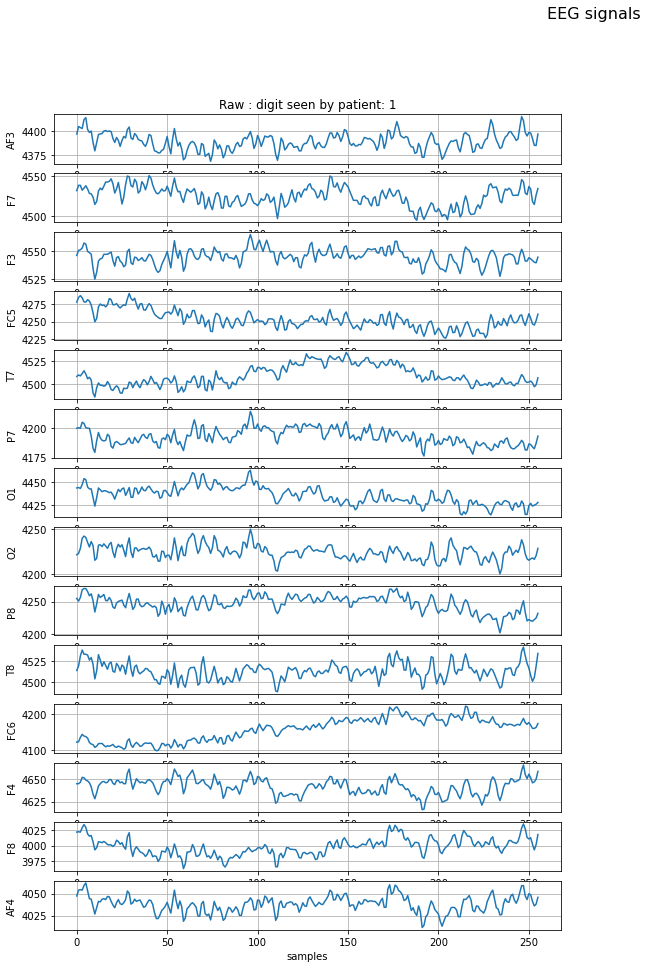

In [15]:
# Display 2 signals with their labels
data_iter = iter(train_loader_raw)
inputs, labels = next(data_iter)
EEGChannel = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]

fig = plt.figure(figsize=(20, 15))
fig.suptitle('EEG signals', fontsize=16)
for i in range(1):
    for j in range(14):
        ax = fig.add_subplot(14, 2, i + 1 + 2 * j)
        if (j == 0):
            ax.set_title(
                'Raw : digit seen by patient: ' + str(labels[i].item()))  # .item() gets the value contained in a tensor
        ax.plot(inputs[i][j])
        ax.set_xlabel('samples')
        ax.set_ylabel(EEGChannel[j])
        ax.grid()

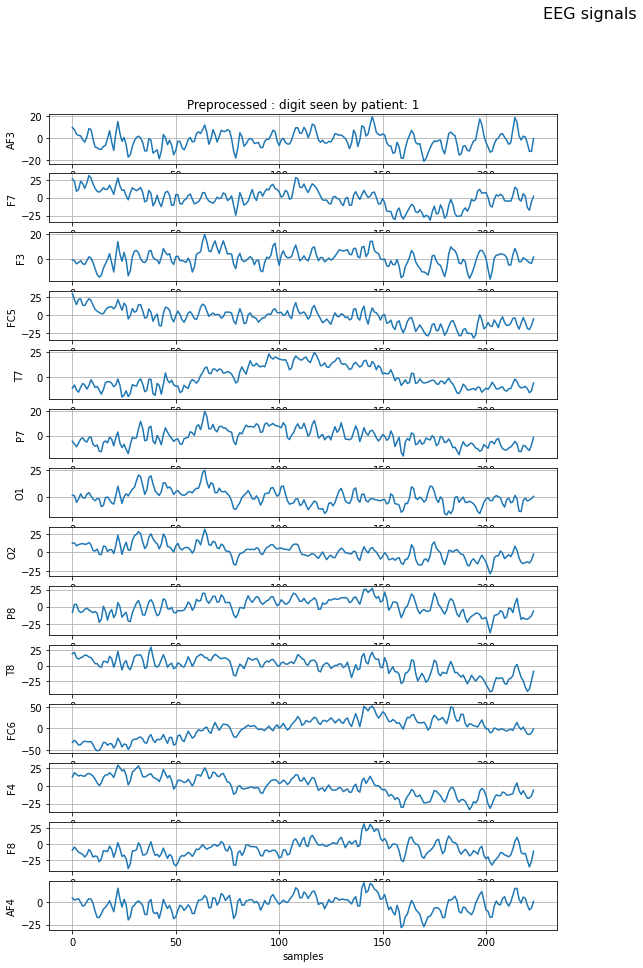

In [19]:
# Display 2 signals with their labels
data_iter = iter(train_loader_preprocessed)
inputs, labels = next(data_iter)
EEGChannel = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]

fig = plt.figure(figsize=(20, 15))
fig.suptitle('EEG signals', fontsize=16)
for i in range(1):
    for j in range(14):
        ax = fig.add_subplot(14, 2, i + 1 + 2 * j)
        if (j == 0):
            ax.set_title(
                'Preprocessed : digit seen by patient: ' + str(labels[i].item()))  # .item() gets the value contained in a tensor
        ax.plot(inputs[i][j])
        ax.set_xlabel('samples')
        ax.set_ylabel(EEGChannel[j])
        ax.grid()

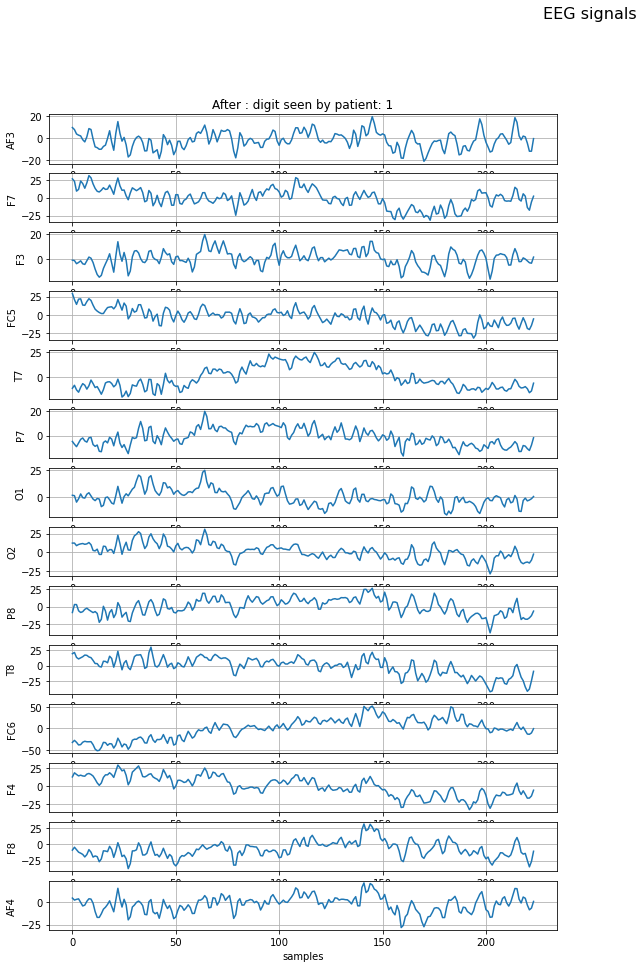

In [21]:
# Display 2 signals with their labels
data_iter = iter(train_loader_reconstructed)
inputs, labels = next(data_iter)
EEGChannel = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]

fig = plt.figure(figsize=(20, 15))
fig.suptitle('EEG signals', fontsize=16)
for i in range(1):
    for j in range(14):
        ax = fig.add_subplot(14, 2, i + 1 + 2 * j)
        if (j == 0):
            ax.set_title(
                'After : digit seen by patient: ' + str(labels[i].item()))  # .item() gets the value contained in a tensor
        ax.plot(inputs[i][j])
        ax.set_xlabel('samples')
        ax.set_ylabel(EEGChannel[j])
        ax.grid()

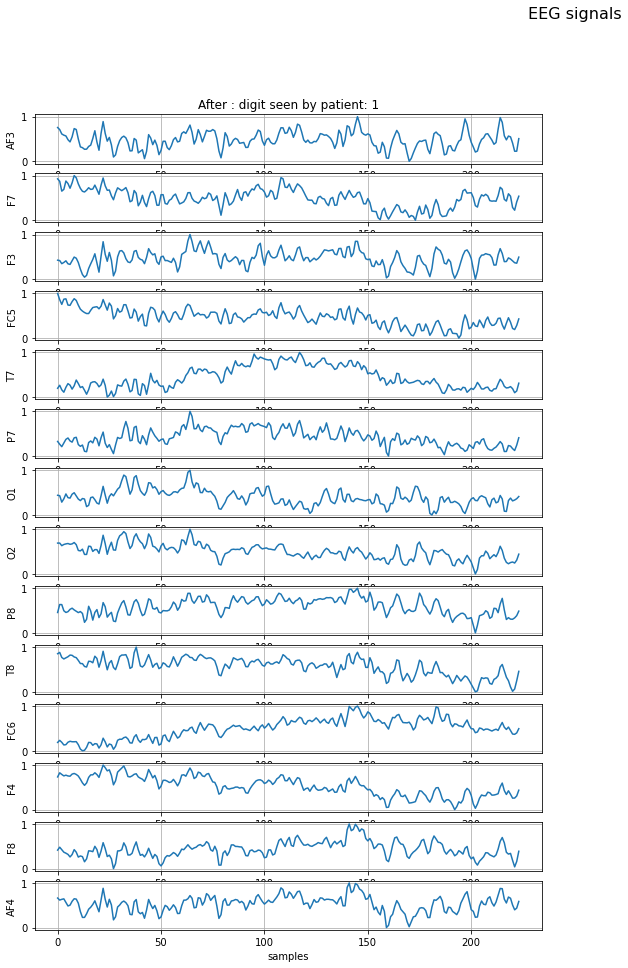

In [26]:
# Display 2 signals with their labels
data_iter = iter(train_loader_standardized)
inputs, labels = next(data_iter)
EEGChannel = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]

fig = plt.figure(figsize=(20, 15))
fig.suptitle('EEG signals', fontsize=16)
for i in range(1):
    for j in range(14):
        ax = fig.add_subplot(14, 2, i + 1 + 2 * j)
        if (j == 0):
            ax.set_title(
                'After : digit seen by patient: ' + str(labels[i].item()))  # .item() gets the value contained in a tensor
        ax.plot(inputs[i][j])
        ax.set_xlabel('samples')
        ax.set_ylabel(EEGChannel[j])
        ax.grid()